## Multibody Simulation of a McPherson Suspension Model
The schematic of the suspension is in the description of the repository. Note that we are using Kane's method [Kane, 1985] and the procedure described in the "Learn Multibody Dynamics" course [Moore] for solving the multibody dynamics. Some parts of this notebook are adapted from [Moore].

In [1]:
import sympy as sm
import sympy.physics.mechanics as me
me.init_vprinting(use_latex = 'mathjax')
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib.animation import FuncAnimation, HTMLWriter
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp

plt.rcParams.update({'font.size': 12}) 

In [2]:
# Variables
#-----------
t                          = me.dynamicsymbols._t

L12, L23, L24, alpha       = sm.symbols('L_{12}, L_{23}, L_{24}, alpha') # lengths on the figure
ks, kt, cs, ms, mu         = sm.symbols('k_s, k_t, c_s, m_s, m_u') # Suspension and tire stiffness and damping coefficient, sprung and unsprung mass
g                          = sm.symbols('g')                       # Gravity constant
rt0,ls0                    = sm.symbols('rt0, ls0')                # Tire and suspension spring initial lengths at equilibrium
zr                         = sm.symbols('zr')                      # Road height

p                          = sm.Matrix([ls0, L12, L23, L24, alpha, rt0, kt, ks, cs, ms, mu, g]) # Vector of parameters

q1, q2, q3, q4             = me.dynamicsymbols('q1, q2, q3, q4')   # Coordinates
q                          = sm.Matrix([q1, q2])                   # Independent generalized coordinates
qr                         = sm.Matrix([q3, q4])                   # Dependent coordinates
qN                         = sm.Matrix([q1, q2, q3, q4])           # All coordinates

u1, u2, u3, u4             = me.dynamicsymbols('u1, u2, u3, u4')   # Speeds
u                          = sm.Matrix([u1, u2])                   # Independent generalized speeds
ur                         = sm.Matrix([u3, u4])                   # Dependent speeds
uN                         = sm.Matrix([u1, u2, u3, u4])           # All speeds

### Reference Frames and Points

In [3]:
# Define the reference frames and points
#---------------------------------------
# Reference frames
N = me.ReferenceFrame('N')
A = me.ReferenceFrame('A')
C = me.ReferenceFrame('C')
U = me.ReferenceFrame('U')
T = me.ReferenceFrame('T')

# Orient the reference frames
C.orient_axis(N, alpha, N.z)
A.orient_axis(N, q2,    N.z)
U.orient_axis(N, q3,    N.z)

# Important points 
O  = me.Point('O')
P1 = me.Point('P1')
P2 = me.Point('P2')
P3 = me.Point('P3')
P4 = me.Point('P4')

# Set the positions for the points
P1.set_pos(O, q1*N.y)
P2.set_pos(P1, -L12*C.x)
P3.set_pos(P2, L23*A.x)
P4.set_pos(P2, L24*A.x)

### Holonomic Constraints
Write down and formulate the holonomic constraints for the suspension geometry:
$$ \mathbf{f}_h(\mathbf{q}, \mathbf{q}_r, t) = \mathbf{0} \in R^M \quad M = \text{number of dependent coordinates and holonomic constraints}$$

In [4]:
# Holonomic constraint (loop of the suspension geometry)
# ------------------------------------------------------
r_P1_P2 = -L12*C.x
r_P2_P3 = L23*A.x
r_P1_P3 = -q4*U.y
loop    = r_P1_P2 + r_P2_P3 - r_P1_P3
loop

-L_{12} c_x + L_{23} a_x + q₄ u_y

In [5]:
# Define the equations for the holonomic constraints
#--------------------------------------------------
fh = sm.Matrix([
    loop.dot(N.x),
    loop.dot(N.y),
])
fh

⎡-L_{12}⋅cos(α) + L_{23}⋅cos(q₂) - q₄⋅sin(q₃)⎤
⎢                                            ⎥
⎣-L_{12}⋅sin(α) + L_{23}⋅sin(q₂) + q₄⋅cos(q₃)⎦

## Kinematics
Write down and formulate the kinematical differential equations:
$$ \mathbf{f}_k(\mathbf{\dot{q}} , \mathbf{\dot{q}}_r, \mathbf{u}, \mathbf{u}_r, \mathbf{q}, \mathbf{q}_r, t) \in R^N \quad N= n + M$$
where
$n =$ number of (independent) generalized coordinates
$$ \mathbf{f}_k = \mathbf{M}_{k} \{ \dot{\mathbf{q}}, \dot{\mathbf{q}}_r\}^T + \mathbf{g}_{k} = \mathbf{0} $$
$$ \{ \dot{\mathbf{q}}, \dot{\mathbf{q}}_r\}^T = -\mathbf{M}_{k}^{-1}\mathbf{g}_{k} $$

In [6]:
# Kinematical differential equations
#-----------------------------------
fk = sm.Matrix([q1.diff(t) - u1,
                q2.diff(t) - u2,
                q3.diff(t) - u3,
                q4.diff(t) - u4,
])

qNd      = qN.diff(t)
qNd_zero = {qNdi:0 for qNdi in qNd}

Mk       = fk.jacobian(qNd)
gk       = fk.xreplace(qNd_zero)

qNd_sol  = -Mk.LUsolve(gk)
qNd_repl = dict(zip(qNd, qNd_sol))
qNd_repl

{q₁̇: u₁, q₂̇: u₂, q₃̇: u₃, q₄̇: u₄}

In [7]:
Mk, gk, me.find_dynamicsymbols(gk) # satisfies that Mk(q, qr, t)

⎛⎡1  0  0  0⎤  ⎡-u₁⎤                  ⎞
⎜⎢          ⎥  ⎢   ⎥                  ⎟
⎜⎢0  1  0  0⎥  ⎢-u₂⎥                  ⎟
⎜⎢          ⎥, ⎢   ⎥, {u₁, u₂, u₃, u₄}⎟
⎜⎢0  0  1  0⎥  ⎢-u₃⎥                  ⎟
⎜⎢          ⎥  ⎢   ⎥                  ⎟
⎝⎣0  0  0  1⎦  ⎣-u₄⎦                  ⎠

Differentiate the holonomic constraints to find the expressions for the dependent speeds:
$$ \mathbf{\dot{f}}_h(\mathbf{u}, \mathbf{u}_r, \mathbf{q}, \mathbf{q}_r, t) = \mathbf{0} \in R^M $$
$$ \mathbf{M}_{hd}\mathbf{u}_r + \mathbf{g}_{hd} = \mathbf{0} $$
$$ \mathbf{u}_r = -\mathbf{M}_{hd}^{-1}\mathbf{g}_{hd} $$

In [8]:
# Time derivative of the holonomic constraints
#--------------------------------------------
fhd = fh.diff(t)
fhd

⎡-L_{23}⋅sin(q₂)⋅q₂̇ - q₄⋅cos(q₃)⋅q₃̇ - sin(q₃)⋅q₄̇⎤
⎢                                               ⎥
⎣L_{23}⋅cos(q₂)⋅q₂̇ - q₄⋅sin(q₃)⋅q₃̇ + cos(q₃)⋅q₄̇ ⎦

Use the kinematical differential equation to replace the time derivatives of the coordinates:


In [9]:
fhd = fhd.xreplace(qNd_repl)
fhd

⎡-L_{23}⋅u₂⋅sin(q₂) - q₄⋅u₃⋅cos(q₃) - u₄⋅sin(q₃)⎤
⎢                                               ⎥
⎣L_{23}⋅u₂⋅cos(q₂) - q₄⋅u₃⋅sin(q₃) + u₄⋅cos(q₃) ⎦

In [10]:
# Obtain the expressions for the dependent speeds
#-----------------------------------------------
ur_zero = {uri: 0 for uri in ur}
Mhd     = fhd.jacobian(ur)
ghd     = fhd.xreplace(ur_zero)
ur_sol  = -Mhd.LUsolve(ghd)
ur_repl = dict(zip(ur, ur_sol))
ur_repl

⎧                         ⎛L_{23}⋅u₂⋅sin(q₂)⋅sin(q₃)                    ⎞     
⎪                         ⎜───────────────────────── + L_{23}⋅u₂⋅cos(q₂)⎟⋅sin(
⎪                         ⎝         cos(q₃)                             ⎠     
⎪    -L_{23}⋅u₂⋅sin(q₂) + ────────────────────────────────────────────────────
⎪                                               2                             
⎪                                            sin (q₃)                         
⎨                                            ──────── + cos(q₃)               
⎪                                            cos(q₃)                          
⎪u₃: ─────────────────────────────────────────────────────────────────────────
⎪                                     q₄⋅cos(q₃)                              
⎪                                                                             
⎪                                                                             
⎩                                                   

Eliminate the dependent speeds so that the kinematical differential equations look like:
$$ \mathbf{f}_k(\mathbf{\dot{q}} , \mathbf{\dot{q}}_r, \mathbf{u}, \mathbf{q}, \mathbf{q}_r, t) \in R^N $$

In [11]:
gk = gk.xreplace(ur_repl)
Mk, gk, me.find_dynamicsymbols(gk)

⎛              ⎡                                      -u₁                     
⎜              ⎢                                                              
⎜              ⎢                                      -u₂                     
⎜              ⎢                                                              
⎜              ⎢ ⎛                     ⎛L_{23}⋅u₂⋅sin(q₂)⋅sin(q₃)             
⎜              ⎢ ⎜                     ⎜───────────────────────── + L_{23}⋅u₂⋅
⎜              ⎢ ⎜                     ⎝         cos(q₃)                      
⎜              ⎢-⎜-L_{23}⋅u₂⋅sin(q₂) + ───────────────────────────────────────
⎜⎡1  0  0  0⎤  ⎢ ⎜                                           2                
⎜⎢          ⎥  ⎢ ⎜                                        sin (q₃)            
⎜⎢0  1  0  0⎥  ⎢ ⎜                                        ──────── + cos(q₃)  
⎜⎢          ⎥, ⎢ ⎝                                        cos(q₃)             
⎜⎢0  0  1  0⎥  ⎢────────────────────────────────────

## Dynamics
Here we develop the dynamical differential equations:

$$  \mathbf{F}_r + \mathbf{F}_r^* = \mathbf{f}_d(\mathbf{\dot{u}}, \mathbf{\dot{u}}_r, \mathbf{u}, \mathbf{u}_r, \mathbf{q}, \mathbf{q}_r, t) = \mathbf{0} $$

However, the dynamics should not include the dependent speeds, so the final form should be:

$$ \mathbf{F}_r + \mathbf{F}_r^* = \mathbf{f}_d(\mathbf{\dot{u}}, \mathbf{u}, \mathbf{q}, \mathbf{q}_r, t) = \mathbf{0} $$

where 

$$ F_r = \sum_{i}^{\nu} {}^{A}\mathbf{v}_r^{P_i}.\mathbf{R}_i \quad \text{is the r-th generalized active force}$$

where $ \mathbf{R}_i $ is the resultant force on the i-th paricle.

$$ F_r^* = \sum_{i}^{\nu} {}^{A}\mathbf{v}_r^{P_i}.\mathbf{R}_i^* \quad \text{is the r-th generalized inertia force}$$

where

$$ \mathbf{R}_i^* = -m_i {}^{A}\mathbf{a}_i^{P_i} $$

is the resultant inertia force on the i-th particle. Here, ${}^{A}v_r^{P_i}$ is the partial velocity of particle $i$ with respect to the $r$-th generalized speed and is obtained via:

$$ \mathbf{v}_r = \frac{\partial \mathbf{v}}{\partial v_r} $$

In [12]:
# Set the velocities for the reference frames
# -------------------------------------------
A.set_ang_vel(N, u2*N.z)    # use u2 instead of q2 due to the assumed kinematic relations
U.set_ang_vel(N, ur_repl[u3]*N.z) # use the ur_repl to eliminate ur's

# Set the velocities for the points
P1.set_vel(N, u1*N.y)
P2.v2pt_theory(P1, N, C)
P3.v2pt_theory(P2, N, A)
P4.v2pt_theory(P2, N, A);

In [13]:
# Create the generalized active forces 
# ------------------------------------
R_P1 = -(q4-ls0)*U.y*ks - ur_repl[u4]*U.y*cs 
R_P2 = 0*N.y 
R_P3 = (q4-ls0)*U.y*ks + ur_repl[u4]*U.y*cs

zu   = P4.pos_from(O).dot(N.y)
R_P4 = -((zu-rt0-zr)*N.y)*kt             


Fr_1 = P1.vel(N).diff(u1, N).dot(R_P1)+\
       P2.vel(N).diff(u1, N).dot(R_P2)+\
       P3.vel(N).diff(u1, N).dot(R_P3)+\
       P4.vel(N).diff(u1, N).dot(R_P4)
       
Fr_2 = P1.vel(N).diff(u2, N).dot(R_P1)+\
       P2.vel(N).diff(u2, N).dot(R_P2)+\
       P3.vel(N).diff(u2, N).dot(R_P3)+\
       P4.vel(N).diff(u2, N).dot(R_P4)


Fr   = sm.Matrix([Fr_1, Fr_2])
Fr

⎡                                                      ⎛     ⎛L_{23}⋅u₂⋅sin(q₂
⎢                                                      ⎜  cₛ⋅⎜────────────────
⎢                                                      ⎜     ⎝         cos(q₃)
⎢kₜ⋅(L_{12}⋅sin(α) - L_{24}⋅sin(q₂) + rt₀ + zr - q₁) + ⎜- ────────────────────
⎢                                                      ⎜                     2
⎢                                                      ⎜                  sin 
⎢                                                      ⎜                  ────
⎢                                                      ⎝                  cos(
⎢                                                                             
⎢                                                         ⎛     ⎛L_{23}⋅u₂⋅sin
⎢                                                         ⎜  cₛ⋅⎜─────────────
⎢                                                         ⎜     ⎝         cos(
⎢              L_{23}⋅(sin(q₂)⋅sin(q₃) + cos(q₂)⋅cos

In [14]:
# Generalized inertia forces
# ---------------------------

P1.set_acc(N, u1.diff(t)*N.y)
P2.a2pt_theory(P1, N, C)
P3.a2pt_theory(P2, N, A)
P4.a2pt_theory(P2, N, A)

Rs_P1 = -ms*P1.acc(N)
Rs_P2 = 0*N.y
Rs_P3 = 0*N.y
Rs_P4 = -mu*P4.acc(N)

Frs_1 = P1.vel(N).diff(u1, N).dot(Rs_P1)+\
        P2.vel(N).diff(u1, N).dot(Rs_P2)+\
        P3.vel(N).diff(u1, N).dot(Rs_P3)+\
        P4.vel(N).diff(u1, N).dot(Rs_P4)

Frs_2 = P1.vel(N).diff(u2, N).dot(Rs_P1)+\
        P2.vel(N).diff(u2, N).dot(Rs_P2)+\
        P3.vel(N).diff(u2, N).dot(Rs_P3)+\
        P4.vel(N).diff(u2, N).dot(Rs_P4)

Frs = sm.Matrix([Frs_1, Frs_2])
Frs, me.find_dynamicsymbols(Frs)


⎛⎡            2                                               ⎤               
⎜⎢L_{24}⋅mᵤ⋅u₂ ⋅sin(q₂) - L_{24}⋅mᵤ⋅cos(q₂)⋅u₂̇ - mₛ⋅u₁̇ - mᵤ⋅u₁̇⎥            
⎜⎢                                                            ⎥, {q₂, u₁, u₂, 
⎜⎢                   2                                        ⎥               
⎝⎣           - L_{24} ⋅mᵤ⋅u₂̇ - L_{24}⋅mᵤ⋅cos(q₂)⋅u₁̇           ⎦             

       ⎞
          ⎟
u₁̇, u₂̇}⎟
       ⎟
         ⎠

After the above, the differential equation for the generalized speeds is:
$$ \mathbf{f}_d(\mathbf{\dot{u}} , \mathbf{u}, \mathbf{q}, \mathbf{q}_r, t) = \mathbf{0} $$
$$ \mathbf{f}_d = \mathbf{M}_d \mathbf{\dot{u}} + \mathbf{g}_d $$
$$ \mathbf{\dot{u}} = -\mathbf{M}_d^{-1} \mathbf{g}_d$$

In [15]:
# Dynamical differential equations
# -------------------------------
Fd      = Fr + Frs
ud      = u.diff(t)
ud_zero = {udi: 0 for udi in ud}
Md      = Fd.jacobian(ud)
gd      = Fd.xreplace(ud_zero)

In [16]:
# check all Mk, gk, Md, and gd to make sure there are no dependent speed terms
# ---------------------------------------------------------------------------
me.find_dynamicsymbols(Mk), me.find_dynamicsymbols(gk),\
me.find_dynamicsymbols(Md), me.find_dynamicsymbols(gd)
# Mk(q, qr, t) OK
# gk(u, q, qr, t) OK
# Md(q, qr, t) OK
# gd(u, q, qr, t) OK

(set(), {q₂, q₃, q₄, u₁, u₂}, {q₂}, {q₁, q₂, q₃, q₄, u₂})

In [17]:
# Create functions for the kinematical and dynamical differential equations
# -------------------------------------------------------------------------
eval_k = sm.lambdify((u, q, qr, p), (Mk, gk))
eval_d = sm.lambdify((u, q, qr, p, zr), (Md, gd))

### Road Input
Here we define one step road input for the simulation.

In [18]:
def step_road(t, vehicle_speed): 
    """
    This function returns the height of the road for a step road at a given
    travel time and for a given travel speed.
    
    Parameters:
    ---------
    t:             float,  time of simulation [s]
    vehicle_speed: float,  vehicle travel speed [m/s] 

    Returns:
    -------
    road_height:   float,  road height at time t [m]
    
    """    
    # Road Parameters:
    step_position = 6 # [m]
    step_height   = 0.05 # [m]

    # Calculate the vehicle position
    vehicle_position = vehicle_speed * t # [m]

    # Road Calculations:
    if vehicle_position >= step_position:
            road_height = step_height
    else:
            road_height = 0    
        
    return road_height

### Simulation

In [19]:
def eval_rhs(t, x, p, v, zr):
    """
    Evaluates the right-hand side of the differential equations.

    Inputs:
        t:  float,     time of the simulation
        x:  ndarray,   containing the state variables
        p:  ndarray,   parameters of the system
        v:  float,     velocity of the vehicle
        zr: function,  road input function

    Outputs:
        xd: ndarray,   time derivative of the differential equations
        
    """
    
    q        = x[0:2]   # [q1, q2]
    qr_guess = x[2:4]   # [q3, q4] initial guess for each time stamp
    u        = x[4:6]   # [u1, u2]

    qr = fsolve(lambda qr, q, p: np.squeeze(eval_fh(qr ,q, p)), qr_guess, args = (q, p))
    
    # road input
    zr_val   = zr(t, v) 
    
    Mk, gk   = eval_k(u, q, qr, p)
    Md, gd   = eval_d(u, q, qr, p, zr_val)

    qNd      = -np.linalg.solve(Mk, gk)
    ud       = -np.linalg.solve(Md, gd)

    xd       = np.hstack((np.squeeze(qNd), np.squeeze(ud)))
    
    return xd

In [20]:
def eval_constraints(xs, p):
    """
    Evaluates the values of the holonomic constraints (the violations).

    Inputs:
        xs: ndarray, states of the system (solution)
        p:  ndarray, parameters of the system
    Outputs:
        con: ndarray, constraint violation values
    """
    con = []
    for xi in xs:  
        q = xi[0:2]
        qr = xi[2:4]
        con.append(eval_fh(qr, q, p).squeeze())
    return np.array(con)

In [21]:
def simulate(eval_rhs, ts, x0, p, v, zr_fun):
    """
    Simulates the system with the given inputs.

    Inputs:
        eval_rhs: function, evaluates the right-hand side of the ODEs.
        ts:       ndarray,  time stamps at which we want the solution
        x0:       ndarray,  initial values of the states
        p:        ndarray,  parameters of the system
        v:        float,    velocity of the vehicle
        zr_fun    function, a function that outputs road height

    Outputs:
        ts:       ndarray,  time stamps
        xs:       ndarray,  solution of the system
        con:      ndarray,  constraint violation values
    """
   
    sol = solve_ivp(eval_rhs, (ts[0], ts[-1]), x0,
                    args = (p, v, zr_fun), t_eval = ts,
                    rtol = 1e-6, atol = 1e-6)

    xs = np.transpose(sol.y)
    ts = sol.t

    # evaluate the constraints
    con = eval_constraints(xs, p)

    return ts, xs, con

### Parameters and the Initial Conditions

In [22]:
# Suspension Parameters:
# ----------------------
rt0_val   = 0.3     # [m]
kt_val    = 183887  # [N/m]
ks_val    = 17658   # [N/m]
cs_val    = 1950    # [N/m/s]
ms_val    = 453     # [kg]
mu_val    = 71      # [kg]
g_val     = 9.81    # [m/s^2]

# Suspension Geometry:
# -------------------
alpha_val  = 75     # [deg]
L12_val    = 0.66   # [m]
L23_val    = 0.35   # [m]
L24_val    = 0.35   # [m]
theta_0    = 0      # Angle of the control arm at the equibilirum [deg]

# Initial values of the generalized coordinates
q2_0       = np.deg2rad(theta_0)                 
q1_0       = rt0_val+L24_val*np.sin(-1*q2_0)+L12_val*np.sin(np.deg2rad(alpha_val))  

# Guess values for the dependent coordinates
q3_guess   = np.deg2rad(0)               # Guess for the angle of the upper strut at equilibrium [deg]
q4_guess   = 0.5                         # Guess for the length of the upper strut at equilibrium [deg]  

#p     = sm.Matrix([ls0, L12, L23, L24, alpha, rt0, kt, ks, cs, ms, mu, g])
p_vals = np.array([
                    q4_guess,                    # ls0 [m]   This will be updated!!!
                    L12_val,                     # L12 [m]
                    L23_val,                     # L23 [m]
                    L24_val,                     # L24 [m]
                    np.deg2rad(alpha_val),       # alpha [rad]
                    rt0_val,                     # rt0 [m]
                    kt_val,                      # kt [N.m]
                    ks_val,                      # ks [N.m]
                    cs_val,                      # cs [N.s/m]
                    ms_val,                      # ms [kg]
                    mu_val,                      # mu [kg]
                    g_val,                       # g [m/s^2] 
])

# q = sm.Matrix([q1, q2])                        # Independent generalized coordinates
q0_vals = np.array([
    q1_0,      # q1 [m] 
    q2_0,      # q2 (rad)
])

qr_guess = np.array([
    q3_guess,    # q3
    q4_guess,    # q4
])

#u = sm.Matrix([u1, u2])                          # Independent generalized speeds
u0_vals         = np.zeros(2)

# Road function
zr_fun          = step_road

# Vehicle velocity
v_val           = 20 # [m/s]

# Simulaiton time
t0_val, tf_val  = 0, 3  # [s]
ts_vals         = np.linspace(t0_val, tf_val, 200)


In [23]:
# Create a function for fh
# ------------------------
eval_fh = sm.lambdify((qr, q, p), fh)

In [24]:
# We have to calculate qr (dependent on q via holonomic constraints) using fsolve
# -------------------------------------------------------------------------------
qr0_vals,_,_,msg = fsolve(
    lambda qr, q, p: np.squeeze(eval_fh(qr, q, p)),  # squeeze to a 1d array
    qr_guess,                                        # initial guess for q2 and q3
    args=(q0_vals, p_vals), full_output=True)        # known values in fh

qr0_vals, msg

(array([0.27399221, 0.66221266]), 'The solution converged.')

In [25]:
# Update the initial length of the spring for equilibrium
#--------------------------------------------------------
p_vals[0] = qr0_vals[1]  

### Time Domain Simulation of Multibody Model

In [26]:
# Simulation;
#-----------
x0_vals         = np.hstack((q0_vals, qr0_vals, u0_vals))
tsol, xsol, con = simulate(eval_rhs, ts_vals, x0_vals, p_vals, v_val, zr_fun)

In [27]:
# Evaluate the time derivatives of the states
#------------------------------------------
xdsol = np.empty((len(tsol), len(x0_vals)))
for i in range(len(tsol)):
    xdsol[i,:] = eval_rhs(tsol[i], xsol[i,:], p_vals, v_val, zr_fun)

In [28]:
# Evaluate the road input
#------------------------------------------
zrsol = np.empty(len(tsol))
for i in range(len(tsol)):
    zrsol[i] = zr_fun(tsol[i], v_val)

In [29]:
def plot_results(tsol, xsol, con):
    """
    Plots the solutions.
    Inputs:
        tsol: ndarray, time stamps of the solution
        xsol: ndarray, solution array
        con:  ndarray, constraint violation array

    """
    fig, axes = plt.subplots(2, 2, sharex = True)
    fig.set_size_inches((11, 6))
    plt.subplots_adjust(hspace=0.4, wspace = 0.4)  # Adjust the width and height padding

    axes[0,0].plot(tsol, xsol[:,[0, 3]])
    axes[0,0].legend(['q1: Sprung mass height', 'q4: Upper strut length'])
    axes[0,0].set_ylabel('Height/Length [m]')  
    axes[0,0].set_title('Sprung Mass Height and Upper Strut Length', pad = 15)


    axes[0,1].plot(tsol, np.rad2deg(xsol[:, [1,2]]))
    axes[0,1].legend(['q2: Control arm angle', 'q3: Upper strut angle'])
    axes[0,1].set_ylabel('Angle [deg]')
    axes[0,1].set_title('Control Arm and Upper Strut Angles', pad = 15)


    axes[1,0].plot(tsol, zrsol)
    axes[1,0].set_ylabel('Height [m]')
    axes[1,0].set_title('Road Input', pad = 15)
    axes[1,0].set_xlabel('Time [s]')

    axes[1,1].plot(tsol, np.squeeze(con)*1e8)
    axes[1,1].legend(['fh1', 'fh2'])
    axes[1,1].set_ylabel('$* 10^{-8}$ [m]')  
    axes[1,1].set_title('Violation of Holonomic Constraints', pad = 15)
    axes[1,1].set_xlabel('Time [s]')

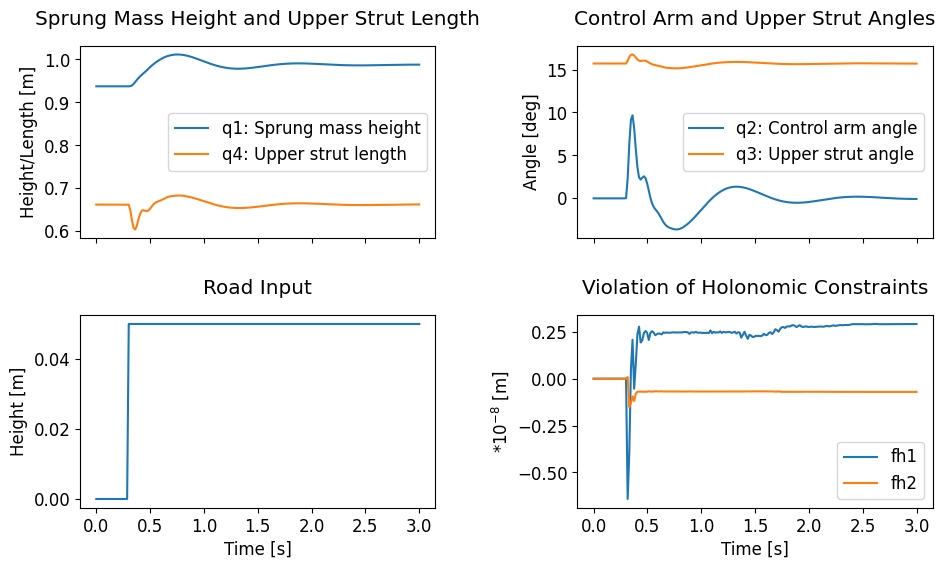

In [30]:
plot_results(tsol, xsol, con)

## Comparison with the Planar Quarter-Car Model
Here, to validate the results of the multibody model, we solve a planar quarter car simulation.

In [31]:
# Planar Qcar Results for validation
# ----------------------------------
import planar_qcar as pqcar

pqc_x0_vals = [0,0,0,0] # [q1, q2, u1, u2] are all set to 
# zero to start from equilibirum. 
# These generalized coordinates are related to the planar quarter car model.
pqc_p_vals  = [ms_val, mu_val, ks_val, kt_val, cs_val]

pqc_tsol, pqc_xsol, pqc_xdsol = pqcar.run_planar_qcar(pqc_x0_vals, pqc_p_vals, t0_val, tf_val, ts_vals, v_val, zr_fun)

pqc_xsol.shape, pqc_xdsol.shape, xsol.shape, xdsol.shape

((200, 4), (200, 4), (200, 6), (200, 6))

In [32]:
def plot_comparison(tsol, xsol, xdsol, pqc_tsol, pqc_xsol, pqc_xdsol):
    
    fig, ax = plt.subplots(2,1, sharex = True, figsize=(6,6))
    plt.subplots_adjust(hspace=0.2, wspace = 0.4) 

    pqc_q1 = pqc_xsol[:,0] # values for the planar quarter car
    q1      = xsol[:,0]    # values for the multibody quarter car
    
    ax[0].plot(pqc_tsol, pqc_q1,        linestyle = '-', label = 'Planar Qcar', color = 'k')
    ax[0].plot(tsol,     q1-q0_vals[0], linestyle = '--', label = 'Multibody Qcar', color = 'red') 
    ax[0].set_ylabel('Displacement [m]')
    ax[0].legend()
    ax[0].set_title('Sprung Mass Response', pad = 15)

    pqc_ud1  = pqc_xdsol[:,2]  # values for the planar quarter car
    ud1      = xdsol[:,4]      # values for the multibody quarter car
       
    ax[1].plot(pqc_tsol, pqc_ud1, linestyle = '-', label = 'Planar Qcar', color = 'k')
    ax[1].plot(tsol,     ud1,     linestyle = '--', label = 'Multibody Qcar', color = 'red')
    ax[1].set_xlabel('Time [s]')
    ax[1].set_ylabel('Acceleration $[m/s^2]$')

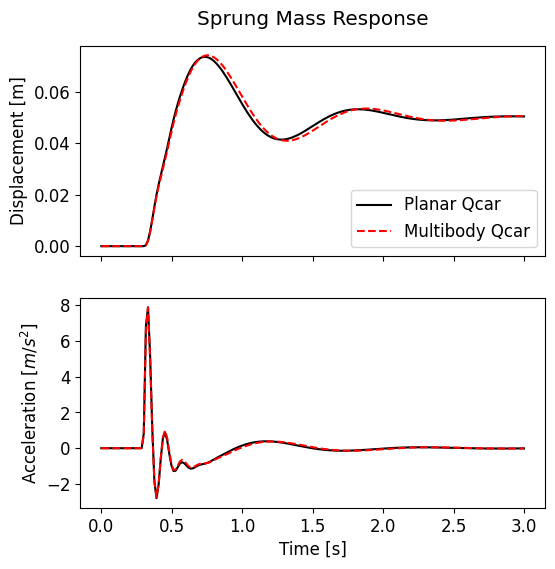

In [33]:
plot_comparison(tsol, xsol, xdsol, pqc_tsol, pqc_xsol, pqc_xdsol)

# Frequency Response Analysis
Here, we simulate the system with a chirp input (sine sweep) and then we generate the transfer function for the gain of the sprung mass acceleration.

In [34]:
def chirp_road(t, v): 

    """
    Generates a chirp road input.

    Inputs:
        t: time of the simulation
        v: vehicle speed
    """
    # Road Parameters:
    min_freq      = 0.001  # [Hz]
    max_freq      = 50     # [Hz]
    chirp_height  = 0.02   # [m]
        
    return scsig.chirp(t, f0=min_freq, f1=max_freq, t1=tf_val, phi = 0, method='linear')*chirp_height

In [35]:
# Simulate the multibody system with the chirp signal
# --------------------------------------------------
import scipy.signal as scsig

#u = sm.Matrix([u1, u2])          # Independent generalized speeds
u0_vals         = np.zeros(2)
zr_fun          = chirp_road

t0_val, tf_val  = 0, 5 # [s]
fps             = 100  
ts_vals         = np.linspace(t0_val, tf_val, num=int(fps*(tf_val - t0_val)), endpoint=False)
v_val           = 20  # [m/s]
x0_vals         = np.hstack((q0_vals, qr0_vals, u0_vals))
ch_tsol, ch_xsol, _ = simulate(eval_rhs, ts_vals, x0_vals, p_vals, v_val, zr_fun)

# Get the speeds
ch_xdsol = np.empty_like(ch_xsol)
for i in range(len(tsol)):
    ch_xdsol[i,:] = eval_rhs(ch_tsol[i], ch_xsol[i,:], p_vals, v_val, zr_fun)

In [36]:
# Simulate the planar system with the chirp signal
# --------------------------------------------------
pqc_x0_vals = [0,0,0,0]
pqc_p_vals  = [ms_val, mu_val, ks_val, kt_val, cs_val]

ch_pqc_tsol, ch_pqc_xsol, ch_pqc_xdsol = pqcar.run_planar_qcar(pqc_x0_vals, pqc_p_vals, t0_val, tf_val, ts_vals, v_val, zr_fun)

In [37]:
def compute_fft(signal, sampling_rate):
    """
    Calculates the one-sided (positive side) FFT of a given signal

    Inputs:
        signal:        ndarray,  signal
        sampling_rate: float,    sampling rate of the signal   
    """

    # Calculate FFT of the signal
    fft_values = np.fft.fft(signal)

    # Calculate frequencies corresponding to FFT values
    frequencies = np.fft.fftfreq(len(signal), d=1/sampling_rate)

    # Find indices corresponding to positive frequencies (one-sided)
    positive_freq_indices = np.where(frequencies >= 0)

    # Take a one-sided FFT result
    one_sided_fft = fft_values[positive_freq_indices]
    
    return frequencies[positive_freq_indices], one_sided_fft

## Bode Diagrams

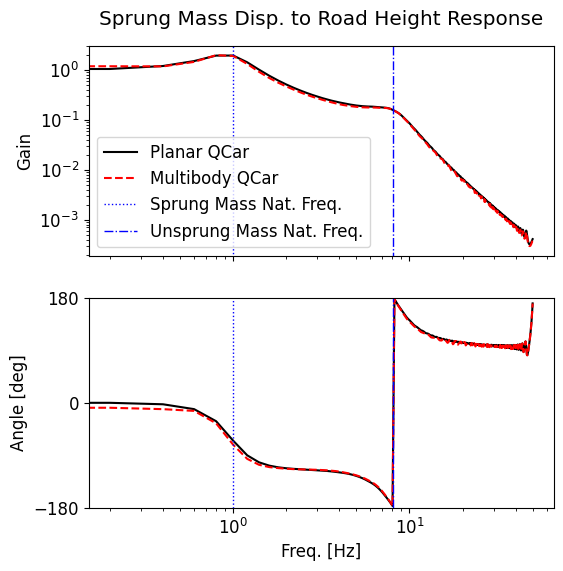

In [38]:
# Bode Diagrams
#-------------

# Calculate the gain values
#-------------------------

ch_zrsol        = np.empty(len(ch_tsol))  # chirp road input
for i in range(len(ch_tsol)):
    ch_zrsol[i] = zr_fun(ch_tsol[i], v_val)

sampling_rate = len(ch_tsol)/(ch_tsol[-1]-ch_tsol[0])
    
freqs, ch_zrsol_fft          = compute_fft(ch_zrsol,                sampling_rate)  # FFT of the road input
_, sprung_mass_disp_fft      = compute_fft(ch_xsol[:,0]-q0_vals[0], sampling_rate)  # FFt of the sprung mass displacement of the multibody model
_, pqc_sprung_mass_disp_fft  = compute_fft(ch_pqc_xsol[:,0],        sampling_rate)  # FFT of the sprung mass displacement of the planar model

sprung_mass_disp_gain        = np.abs(sprung_mass_disp_fft/ch_zrsol_fft)
pqc_sprung_mass_disp_gain    = np.abs(pqc_sprung_mass_disp_fft/ch_zrsol_fft)

sprung_mass_disp_phase       = np.angle(sprung_mass_disp_fft/ch_zrsol_fft)*180/(np.pi)     # [rad] -> [deg]
pqc_sprung_mass_disp_phase   = np.angle(pqc_sprung_mass_disp_fft/ch_zrsol_fft)*180/(np.pi) # [rad] -> [deg]


sprung_mass_nat_feq          = np.sqrt(ks_val/ms_val)/(2*np.pi)  # sprung mass natural frequency [Hz]
unsprung_mass_nat_feq        = np.sqrt(kt_val/mu_val)/(2*np.pi)  # unsprung mass natural frequency [Hz]

# Plotting the bode diagrams
# -------------------------
fig, ax                      = plt.subplots(2,1, sharex = True, figsize=(6,6))

ax[0].loglog(freqs, pqc_sprung_mass_disp_gain, '-',   color = 'k',   label = 'Planar QCar');
ax[0].loglog(freqs, sprung_mass_disp_gain,     '--' , color = 'red', label = 'Multibody QCar')

ax[0].vlines(sprung_mass_nat_feq, 1e-5, 10,   linestyles = ':',  color = 'b', linewidth = 1, label = 'Sprung Mass Nat. Freq.')
ax[0].vlines(unsprung_mass_nat_feq, 1e-5, 10, linestyles = '-.', color = 'b', linewidth = 1, label = 'Unsprung Mass Nat. Freq.')
ax[0].legend()
ax[0].set_title('Sprung Mass Disp. to Road Height Response', pad = 15);
ax[0].set_ylabel('Gain')

ax[1].semilogx(freqs, pqc_sprung_mass_disp_phase, '-',  color = 'k')
ax[1].semilogx(freqs, sprung_mass_disp_phase,     '--', color = 'r')


ax[1].vlines(sprung_mass_nat_feq, -180, 180,   linestyles = ':',  color = 'b', linewidth = 1, label = 'Sprung Mass Nat. Freq.')
ax[1].vlines(unsprung_mass_nat_feq, -180, 180, linestyles = '-.', color = 'b', linewidth = 1, label = 'Unsprung Mass Nat. Freq.')
ax[1].set_xlabel('Freq. [Hz]')
ax[1].set_ylim([-180, 180])
ax[1].set_yticks([-180, 0, 180])
ax[1].set_ylabel('Angle [deg]');

## References:
- Hong, K. S., Jeon, D. S., & Sohn, H. C. (1999, June). A new modeling of the Macpherson suspension system and its optimal pole-placement control. In Proceedings of the 7th Mediterranean Conference on Control and Automation (MED99) (pp. 559-579).
- Thomas R. Kane, and David A. Levinson. Dynamics, Theory and Application. McGraw Hill, 1985
- Moore, J. K., “Learn Multibody Dynamics”, 2022, https://moorepants.github.io/learn-multibody-dynamics/